In [1]:
import numpy as np
from icecream import ic
from matplotlib import pyplot as plt
from itertools import accumulate


Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [2]:
UNIVERSE_SIZE = 1_000 # 100_000
NUM_SETS = 100 # 10_000
DENSITY = 0.2 # 0.3
MAX_STEPS = 10_000

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [3]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.power(SETS.sum(axis=1), 1.1)

## Helper Functions

In [4]:
def valid(solution):
    """Checks whether solution is valid (i.e. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Solution examples

In [5]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(True, 33471.32124271869)

In [6]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(True, 15552.83636726931)

In [7]:
def single_mutation(solution: np.ndarray) -> np.ndarray:
    """Tweaks the solution by adding/removing a random set"""
    new_sol = solution.copy()
    index = rng.integers(0, NUM_SETS)
    new_sol[index] = not new_sol[index]
    return new_sol


def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    """Tweaks the solution by adding/removing multiple sets """
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01
    new_sol = np.logical_xor(new_sol, mask)
    return new_sol

def multiple_mutation_strength(solution: np.ndarray, strength: float = 0.01) -> np.ndarray:
    """Tweaks the solution by adding/removing multiple sets """
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[rng.integers(0, NUM_SETS)] = True  # At least one mutation
    new_sol = np.logical_xor(new_sol, mask)
    return new_sol

def fitness(solution: np.ndarray):
    """Returns the fitness of a solution"""

    return valid(solution), -cost(solution)  # I want a valid solution that minimizes the cost

In [8]:
def plot(costs):
    """ Scatter plot of costs, and a line plot of the best cost """
    x = list(range(len(costs)))
    plt.figure(figsize=(10, 5))
    plt.scatter(x, costs, label='Fitness', s=3)
    plt.plot(x, list(accumulate(costs, max)), label='Best fitness', color='red')
    plt.xlabel('Steps')
    plt.ylabel('Fitness')
    plt.legend()
    plt.grid()
    plt.show()

ic| fitness(solution): (True, -33471.32124271869)
ic| fitness(solution): (True, -7512.81001676725)


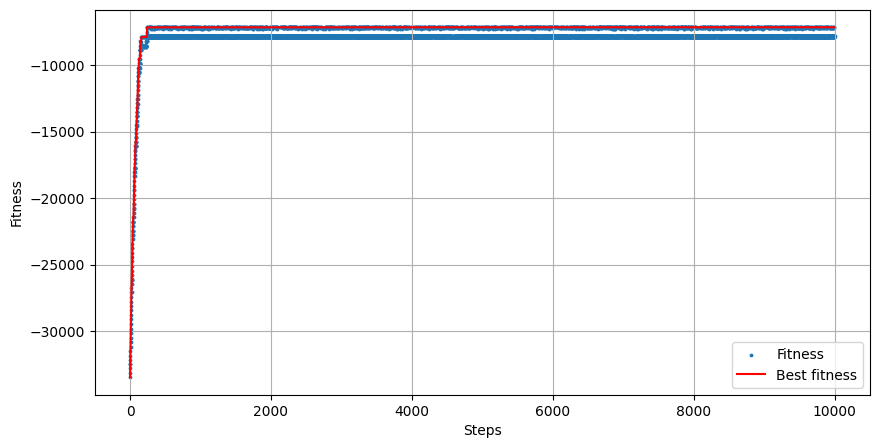

In [9]:
# Professor's solution: RMHC with single mutation
tweak = single_mutation
solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
ic(fitness(solution))
history = [solution_fitness[1]]

for _ in range(MAX_STEPS):
    new_solution = tweak(solution)
    history.append(fitness(new_solution)[1])
    if fitness(new_solution) > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))
plot(history)


ic| fitness(solution): (True, -33471.32124271869)
ic| fitness(solution): (True, -6866.93200210774)


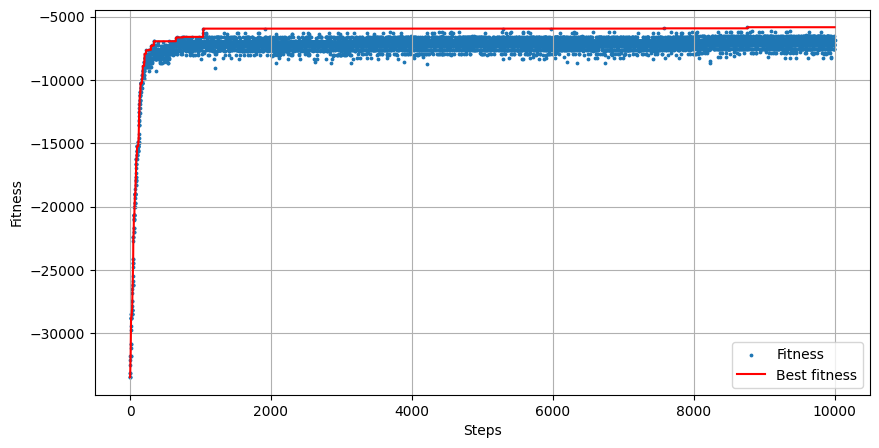

In [10]:
# Professor's solution: RMHC with multiple mutations
tweak = multiple_mutation
solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
ic(fitness(solution))
history = [solution_fitness[1]]

for _ in range(MAX_STEPS):
    new_solution = tweak(solution)
    history.append(fitness(new_solution)[1])
    if fitness(new_solution) > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))
plot(history)

ic| fitness(solution): (True, -33471.32124271869)
ic| fitness(solution): (True, -6941.399710747063)


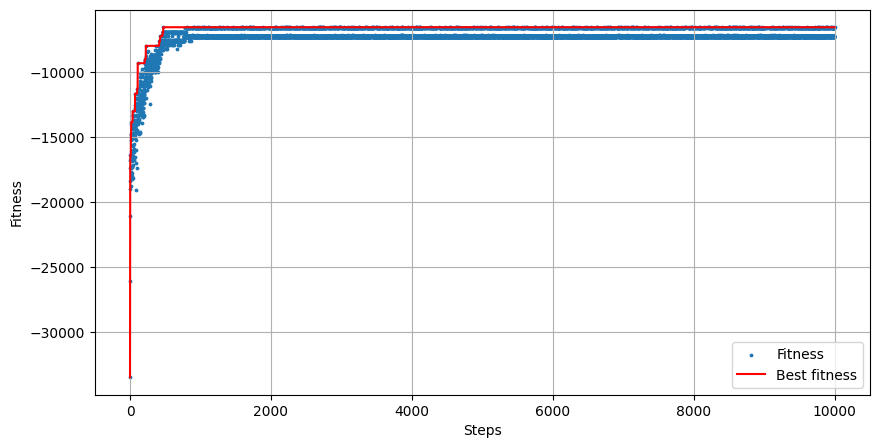

In [11]:
# Professor's solution: RMHC with multiple mutations and adapting strength
tweak = multiple_mutation_strength
strength = 0.5
solution = rng.random(NUM_SETS) < 1 # Take all sets
solution_fitness = fitness(solution)
ic(fitness(solution))
history = [solution_fitness[1]]

for step in range(MAX_STEPS):
    if step % 100 == 0: # Strength adaptation
        strength /= 2
    new_solution = tweak(solution, strength)
    history.append(fitness(new_solution)[1])
    if fitness(new_solution) > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))
plot(history)

## Proposed solutions

### Solution 1

ic| fitness(solution): (True, -33471.32124271869)
ic| fitness(solution): (True, -9966.008945893538)


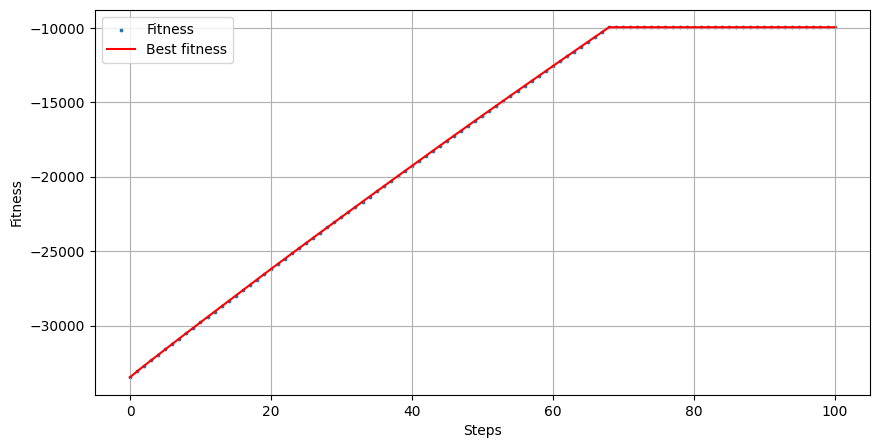

In [12]:
# Proposed solution: start from all sets, then remove the ones with the highest cost (if the solution is still valid)
solution = np.full(NUM_SETS, True)

ic(fitness(solution))
history = [fitness(solution)[1]]
sets_to_consider = np.ones(NUM_SETS, dtype=bool)  # keep track of removed sets so that we don't remove them again (1=not removed, 0=removed)

for _ in range(len(COSTS)):
    # Find the set with the highest cost
    index = np.argmax(sets_to_consider * COSTS)  # ignore already removed sets
    sets_to_consider[index] = False

    new_solution = solution.copy()
    new_solution[index] = False
    if valid(new_solution):
        solution = new_solution
    else:
        sets_to_consider[index] = True
    history.append(fitness(solution)[1])

ic(fitness(solution))
plot(history)

### Solution 2: Greedy Algorithm

With this implementation the intermediate solutions are not valid, only the last one is.
That's why in the plot the cost is ascending: I'm adding sets and never removing them.

ic| fitness(solution): (True, -6122.934596405414)


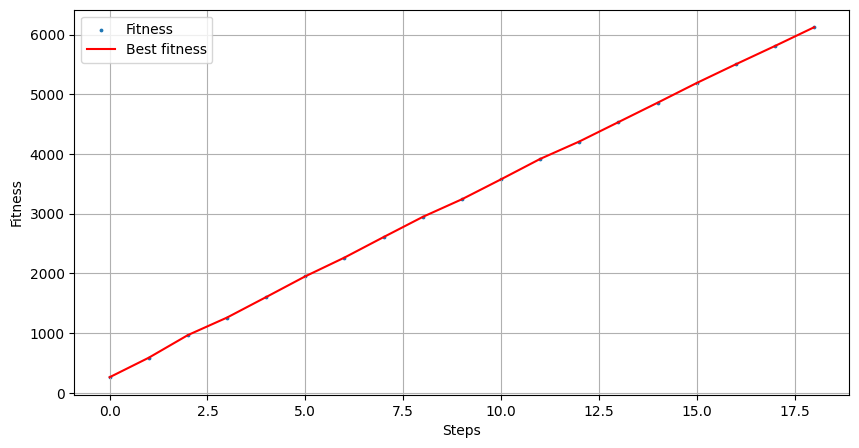

In [13]:
# Greedy algorithm for Set Cover Problem. In this case, only the last solution is valid!
universe_size = SETS.shape[1]
uncovered = np.ones(universe_size, dtype=bool)  # Start with all elements uncovered
solution = np.ndarray(0, dtype=int)  # Start with an empty solution
history = []

while uncovered.any():  # While there are still uncovered elements
    coverage = SETS[:, uncovered].sum(axis=1)  # Calculate the number of uncovered elements each set covers
    ratio = coverage / COSTS  # Compute coverage-to-cost ratio (how much does each set cover for its cost?)
    best_set = np.argmax(ratio)  # Select the set with the highest coverage-to-cost ratio
    solution = np.append(solution, best_set)  # Add the best set to the solution
    uncovered[SETS[best_set]] = False  # Mark the elements covered by this set as covered
    fitness_sol = fitness(solution)
    history.append(-fitness_sol[1])  # Append the cost of the solution

ic(fitness(solution))
plot(history)

### Solution 3: Simulated Annealing

Note: hyperparameters have been chosen arbitrarily by looking at the resulting plots, and may not be optimal.

ic| fitness(best_solution): (True, -6882.16456054578)


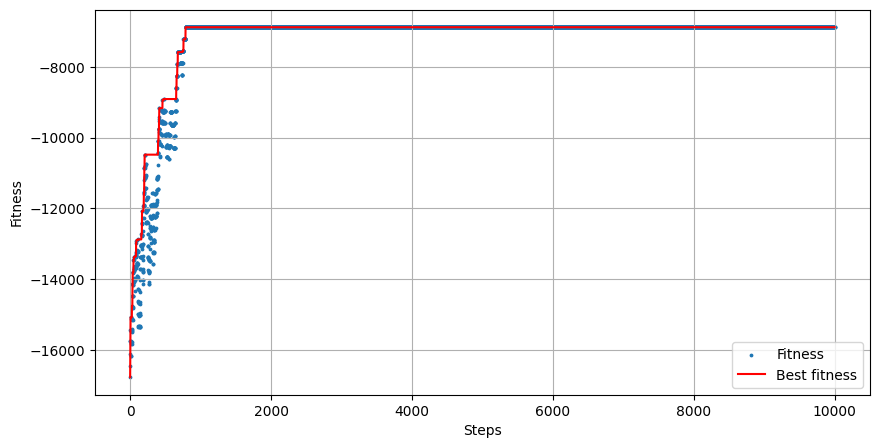

In [14]:
# Simulated Annealing for Set Cover Problem
universe_size = SETS.shape[1]
num_sets = SETS.shape[0]

# Start with a random solution (random subset of sets)
current_solution = np.random.choice([True, False], size=num_sets)
best_solution = current_solution.copy()
fitness_best_solution = fitness(best_solution)
fitness_current_solution = fitness_best_solution

temp = 1000.0  # Initial temperature
cooling_rate = 0.997  # Cooling rate
history = [fitness(current_solution)[1]]
tweak = single_mutation  # Use the single mutation tweak function

for _ in range(MAX_STEPS):
    new_solution = tweak(current_solution)  # Generate a neighboring solution
    fitness_new_solution = fitness(new_solution)

    # Determine if we should accept the new solution
    delta_fitness = fitness_new_solution[1] - fitness_current_solution[1]  # Fitness difference
    if fitness_new_solution[0] and (delta_fitness > 0 or np.random.random() < np.exp(delta_fitness / temp)):  # Valid and (better or accepted by chance)
        current_solution = new_solution
        fitness_current_solution = fitness_new_solution

    if fitness_current_solution > fitness_best_solution:  # Update the best solution if the current one is better
        best_solution = current_solution
        fitness_best_solution = fitness_current_solution

    temp *= cooling_rate  # Reduce the temperature
    history.append(fitness_current_solution[1])

ic(fitness(best_solution))
plot(history)